In [1]:
import pandas as pd
import numpy as np

import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import median
from sklearn.utils import resample

# ALGOS
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn import svm


from sklearn import metrics
from sklearn.utils import resample
from imblearn.pipeline import make_pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import NearMiss
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import jaccard_score
from sklearn.metrics import mean_squared_log_error,mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve

import itertools

import warnings

warnings.filterwarnings('ignore')

In [2]:
modelling_df = pd.read_csv('../data/sinave4.csv')

In [3]:
modelling_df.shape

(341990, 74)

In [4]:
# modelling_df.info()

In [5]:
modelling_df['estado'].value_counts(normalize = True)

ACTIVOS LEVES     0.474917
RECUPERADOS       0.451844
FALLECIDOS        0.057241
ACTIVOS GRAVES    0.015998
Name: estado, dtype: float64

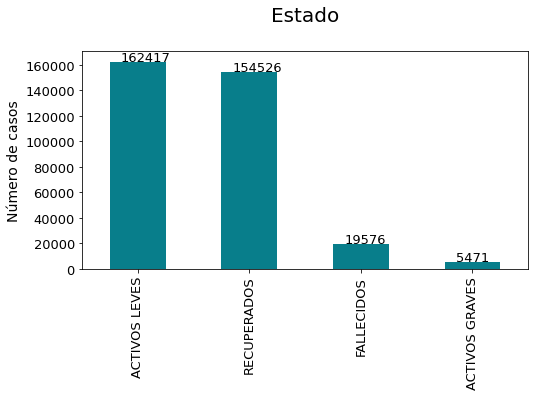

In [6]:
ax = modelling_df['estado'].value_counts().plot(kind='bar', figsize=(8, 4), fontsize=13, color='#087E8B')
ax.set_title('Estado', size=20, pad=30)
ax.set_ylabel('Número de casos', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.10, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=13)

In [7]:
modelling_df3_2cat = modelling_df.copy()

In [8]:
modelling_df3_2cat['estado'].replace(to_replace=['ACTIVOS LEVES', 'RECUPERADOS', 'FALLECIDOS', 'ACTIVOS GRAVES'],value=['RECUPERADOS','RECUPERADOS','FALLECIDOS','FALLECIDOS'],inplace=True)

In [9]:
# modelling_df3_2cat = modelling_df3_2cat[modelling_df3_2cat["estado"].isin(['RECUPERADOS','FALLECIDOS'])]

In [10]:
modelling_df3_2cat.estado.unique()

array(['RECUPERADOS', 'FALLECIDOS'], dtype=object)

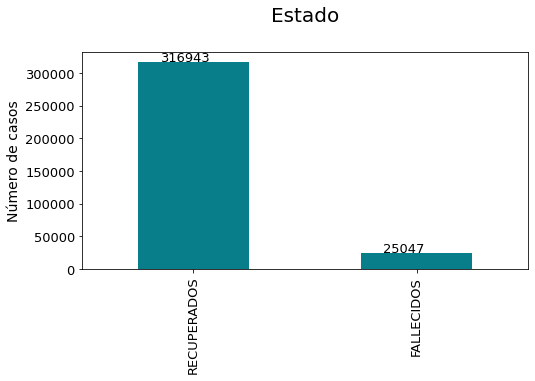

In [11]:
ax = modelling_df3_2cat['estado'].value_counts().plot(kind='bar', figsize=(8, 4), fontsize=13, color='#087E8B')
ax.set_title('Estado', size=20, pad=30)
ax.set_ylabel('Número de casos', fontsize=14)

for i in ax.patches:
    ax.text(i.get_x() + 0.10, i.get_height() + 700, str(round(i.get_height(), 2)), fontsize=13)

In [12]:
# Convert to dummies
modelling_df3_2cat['estado'].replace(to_replace=['RECUPERADOS', 'FALLECIDOS'], 
                                     value=[1,0],inplace=True)

In [13]:
modelling_df3_2cat_test = modelling_df3_2cat.sample(n=20,random_state=200) #random state is a seed value
modelling_df4_2cat = modelling_df3_2cat.drop(modelling_df3_2cat_test.index)

In [14]:
modelling_df3_2cat_test.shape

(20, 74)

In [ ]:
modelling_df4_2cat['estado'].value_counts()

# SEMIBALANCED BICLASS

In [ ]:
# sm = SMOTE(random_state = 42)

In [ ]:
# X, y = sm.fit_resample(X, y)

### RESAMPLE

In [15]:
features = ['fiebre', 'tos','odinofagia','disnea','irritabilidad','diarrea','dolor_toracico','calofrios', 'cefalea','mialgias','artralgias','ataque_al_estado_general','rinorrea','polipnea','vomito','dolor_abdominal','conjuntivitis','cianosis','diabetes', 'epoc', 'asma', 'inmunosupresivo','hipertension', 'VIH_SIDA', 'otra_condicion', 'enfermedad_cardiaca','obesidad', 'insuficiencia_renal_cronica', 'tabaquismo', 'diabetes', 'epoc', 'asma', 'inmunosupresivo',
       'hipertension', 'VIH_SIDA', 'otra_condicion', 'enfermedad_cardiaca',
       'obesidad', 'insuficiencia_renal_cronica', 'tabaquismo']

In [16]:
X = modelling_df4_2cat[features].copy()
y = modelling_df4_2cat['estado'].copy()

In [17]:
X = np.array(X)

In [19]:
count_class_0 = 60090
count_class_1 = 25045
pipe = make_pipeline(SMOTE(sampling_strategy={0: count_class_0}), NearMiss(sampling_strategy={1: count_class_1}))

X, y = pipe.fit_resample(X, y)

In [20]:
from collections import Counter
counter = Counter(y)

for k,v in counter.items():
    per = v / len(y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))

Class=0, n=60090 (70.582%)
Class=1, n=25045 (29.418%)


In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (68108, 40) (68108,)
Test set: (17027, 40) (17027,)


In [22]:
# estandarizamos los datos

ss = preprocessing.StandardScaler().fit(X_train.astype(np.float))
X_train = ss.transform(X_train.astype(np.float))
X_test = ss.transform(X_test.astype(np.float))

## Logistic Regression Classifier

In [23]:
# Confusion Matrix plotting function
# https://towardsdatascience.com/multi-class-classification-extracting-performance-metrics-from-the-confusion-matrix-b379b427a872

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    


In [24]:
# Encuentra los mejores hiperparámetros para logistic regression classifier
#Logistic Regression soporta solo solvers en ['liblinear', 'newton-cg', 'lbfgs', 'sag', 'saga']

solvers = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
cs = [0.0001, 0.001, 0.01, 0.1, 1, 10, 100]
results_df = pd.DataFrame(index=cs)
results_df.index.name='C'
for s in solvers:
    results = []
    for c in cs:
        LR = LogisticRegression(C=c, solver=s, max_iter=4000, random_state=42).fit(X_train,y_train)
        y_pred = LR.predict(X_test)
        j_score = jaccard_score(y_test, y_pred)
        results.append(j_score)
    results_df[s] = results
results_df

,newton-cg,lbfgs,liblinear,sag,saga
C,,,,,
0.0001,0.638792,0.638792,0.643927,0.638792,0.638792
0.0010,0.660143,0.660143,0.665157,0.660143,0.660143
0.0100,0.660958,0.660958,0.659445,0.660958,0.660958
0.1000,0.660741,0.660741,0.660632,0.660741,0.660741
1.0000,0.660741,0.660741,0.661399,0.660741,0.660741
10.0000,0.661399,0.661399,0.661399,0.661399,0.661399
100.0000,0.661399,0.661399,0.661399,0.661399,0.661399


Confusion matrix, without normalization


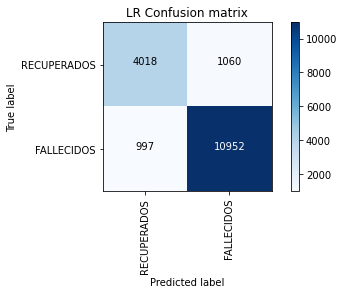

In [25]:
import itertools


# Ejecutamos logistic regression classifier y mostramos resultados

LR = LogisticRegression(C=10.0000, solver='newton-cg', random_state=42).fit(X_train,y_train)
y_pred = LR.predict(X_test)
y_pred_train = LR.predict(X_train)


LR_j_score = jaccard_score(y_test, y_pred)
LR_j_score_train = jaccard_score(y_train, y_pred_train)

LR_f_score = f1_score(y_test, y_pred, average='weighted')
LR_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

LR_class_report = classification_report(y_test, y_pred)
LR_class_report_train = classification_report(y_train, y_pred_train)

LR_dict = classification_report(y_test, y_pred, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS', 'FALLECIDOS'],normalize=False,  title='LR Confusion matrix')

In [26]:
print('Logistic Regression train jaccard score:', round(LR_j_score_train, 4))
print('Logistic Regression test jaccard score:', round(LR_j_score, 4))

print('\nLogistic Regression TRAIN classification report:\n\n', LR_class_report_train)
print('Logistic Regression TEST classification report:\n\n', LR_class_report)

Logistic Regression train jaccard score: 0.6578
Logistic Regression test jaccard score: 0.6614

Logistic Regression TRAIN classification report:

               precision    recall  f1-score   support

           0       0.91      0.92      0.92     48141
           1       0.80      0.78      0.79     19967

    accuracy                           0.88     68108
   macro avg       0.86      0.85      0.85     68108
weighted avg       0.88      0.88      0.88     68108

Logistic Regression TEST classification report:

               precision    recall  f1-score   support

           0       0.91      0.92      0.91     11949
           1       0.80      0.79      0.80      5078

    accuracy                           0.88     17027
   macro avg       0.86      0.85      0.86     17027
weighted avg       0.88      0.88      0.88     17027



## Decision Tree Classifier

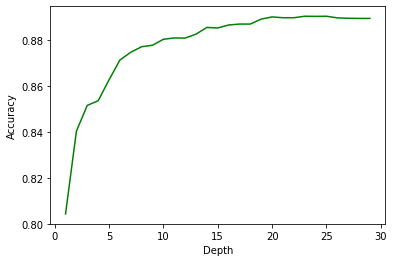

The best accuracy is 0.8904 with depth= 23


In [27]:
depth = 30 #30
mean_acc = np.zeros((depth-1))
for n in range(1,depth): 
    DT = DecisionTreeClassifier(criterion="entropy", max_depth = n, random_state=42).fit(X_train,y_train)
    y_pred=DT.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
plt.plot(range(1,depth),mean_acc,'g')
plt.ylabel('Accuracy')
plt.xlabel('Depth')
plt.show()
print("The best accuracy is", round(mean_acc.max(), 4), "with depth=", mean_acc.argmax()+1)

Confusion matrix, without normalization


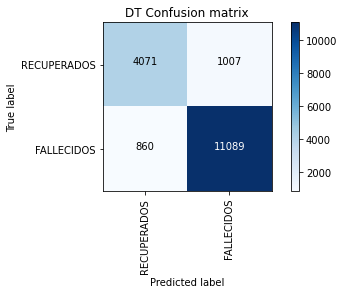

In [28]:
# rejecuta el decision tree classifier y muestra los resultados

DT = DecisionTreeClassifier(criterion="entropy", max_depth = 23, random_state=42).fit(X_train, y_train)
y_pred = DT.predict(X_test)
y_pred_train = DT.predict(X_train)


DT_j_score = jaccard_score(y_test, y_pred)
DT_j_score_train = jaccard_score(y_train, y_pred_train)

DT_f_score = f1_score(y_test, y_pred, average='weighted')
DT_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

DT_class_report = classification_report(y_test, y_pred)
DT_class_report_train = classification_report(y_train, y_pred_train)

DT_dict = classification_report(y_test, y_pred, output_dict=True)
DT_dict_train = classification_report(y_train, y_pred_train, output_dict=True)

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='DT Confusion matrix')

In [29]:
print('Decision Tree TRAIN jaccard score:', round(DT_j_score_train, 2),
      '\nDecision Tree TEST jaccard score:', round(DT_j_score, 2))

print('\nDecision Tree TRAIN classification report:\n\n', DT_class_report_train)
print('\nDecision Tree TEST classification report:\n\n', DT_class_report)

Decision Tree TRAIN jaccard score: 0.71 
Decision Tree TEST jaccard score: 0.69

Decision Tree TRAIN classification report:

               precision    recall  f1-score   support

           0       0.92      0.94      0.93     48141
           1       0.85      0.81      0.83     19967

    accuracy                           0.90     68108
   macro avg       0.88      0.87      0.88     68108
weighted avg       0.90      0.90      0.90     68108


Decision Tree TEST classification report:

               precision    recall  f1-score   support

           0       0.92      0.93      0.92     11949
           1       0.83      0.80      0.81      5078

    accuracy                           0.89     17027
   macro avg       0.87      0.86      0.87     17027
weighted avg       0.89      0.89      0.89     17027



## Random Forest Classifier

In [ ]:
# n_estimators = [100, 300, 500, 800]
# max_depth = [5, 8, 15, 25, 30]
# min_samples_split = [10, 15, 100]
# min_samples_leaf = [1, 2, 5, 10]

In [ ]:
# gs = GridSearchCV(
#     estimator = RandomForestClassifier(), 
#     param_grid = {
#           "n_estimators" : n_estimators,
#           "max_depth" : max_depth,
#           "min_samples_split" : min_samples_split,
#           "min_samples_leaf" : min_samples_leaf,
#           },
#           cv=5,
#           verbose=3,
#           scoring = "neg_root_mean_squared_error",
#           return_train_score = True
# )

In [ ]:

# %%time
# gs.fit(X_train, y_train)

In [ ]:
# grid_search_results = pd.DataFrame(gs.cv_results_)

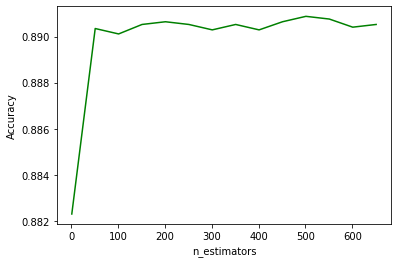

The best accuracy is 0.8909 with n_estimators= 501


In [30]:
depth = 700
mean_acc = np.zeros((depth-1))
for n in range(1,depth,50): 
    RF = RandomForestClassifier(n_estimators = n, random_state = 42).fit(X_train,y_train)
    y_pred = RF.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, y_pred)
plt.plot(range(1,depth,50),mean_acc[::50],'g')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()
print( "The best accuracy is", round(mean_acc.max(), 4), "with n_estimators=", mean_acc.argmax()+1)

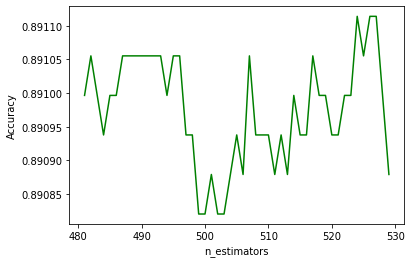

The best accuracy is 0.8911 with n_estimators= 524


In [32]:
depth = 530
mean_acc = np.zeros((depth-1))
# for n in range(1,depth,501): 
for n in range(480,depth): 
    RF = RandomForestClassifier(n_estimators=n, random_state=42).fit(X_train,y_train)
    yhat=RF.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
# plt.plot(range(1,depth,501),mean_acc[::501],'g')
plt.plot(range(481,depth),mean_acc[480:530],'g')
plt.ylabel('Accuracy')
plt.xlabel('n_estimators')
plt.show()
print( "The best accuracy is", round(mean_acc.max(), 4), "with n_estimators=", mean_acc.argmax()+1)


Confusion matrix, without normalization


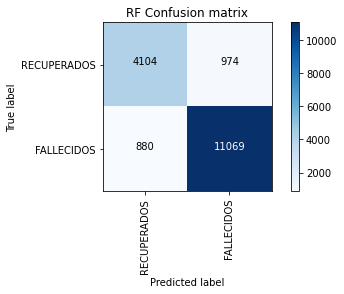

In [33]:
# ejecutar random forest y mostrar resultados

RF = RandomForestClassifier(n_estimators=524, random_state=42).fit(X_train, y_train)
y_pred = RF.predict(X_test)
y_pre_train = RF.predict(X_train)


RF_j_score = jaccard_score(y_test, y_pred)
RF_j_score_train = jaccard_score(y_train, y_pred_train)


RF_f_score = f1_score(y_test, yhat, average='weighted')
RF_f_score_train = f1_score(y_train, y_pred_train, average='weighted')

RF_class_report = classification_report(y_test, y_pred)
RF_class_report_train = classification_report(y_train, y_pred_train)


RF_dict = classification_report(y_test, y_pred, output_dict=True)
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred, labels=[1,0])
np.set_printoptions(precision=2)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['RECUPERADOS','FALLECIDOS'],normalize=False,  title='RF Confusion matrix')

## K-Nearest Neighbors (KNN) Classifier

In [ ]:
# encontrar los mejores hiperparámetros para K-Nearest Neighbors (KNN) Classifier, solo k impar

Ks = 38 #38
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))
ConfustionMx = [];
for n in range(1,Ks):
    #Train Model and Predict  
    KNN = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat= KNN.predict(X_test)
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)
    
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

In [ ]:
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy ', '+/- 3xstd'))

plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (K)')
plt.show()
print("The best accuracy was with", round(mean_acc.max(), 4), "with k=", mean_acc.argmax()+1)